In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nibabel cryptography numpy

In [ ]:
def normalize_and_resize_nii(file_path, target_shape=(256, 256, 128)):
    """
    Chuẩn hóa và resize ảnh .nii về kích thước cố định.
    """
    # Đọc file .nii
    img = nib.load(file_path)
    data = img.get_fdata()

    # Chuyển dữ liệu về kiểu float32
    data = data.astype(np.float32)

    # Lấy kích thước gốc
    original_shape = data.shape

    # Tạo một mảng rỗng với kích thước mục tiêu
    resized_data = np.zeros(target_shape, dtype=np.float32)

    # Tính toán để crop hoặc pad ảnh
    min_shape = np.minimum(original_shape, target_shape)
    crop_start = [(o - m) // 2 for o, m in zip(original_shape, min_shape)]
    crop_end = [start + m for start, m in zip(crop_start, min_shape)]
    pad_start = [(t - m) // 2 for t, m in zip(target_shape, min_shape)]
    pad_end = [start + m for start, m in zip(pad_start, min_shape)]

    # Cắt trung tâm (crop)
    slices = tuple(slice(start, end) for start, end in zip(crop_start, crop_end))
    cropped_data = data[slices]

    # Padding để đạt kích thước mục tiêu
    resized_data[tuple(slice(start, end) for start, end in zip(pad_start, pad_end))] = cropped_data

    # Tạo file .nii mới với dữ liệu đã resize
    resized_img = nib.Nifti1Image(resized_data, img.affine, img.header)

    return resized_img


In [ ]:
import nibabel as nib
import os
import numpy as np
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.padding import PKCS7
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

# Danh sách các thư mục chứa file .nii đã chuẩn hóa
INPUT_FOLDERS = ["/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data/Final_normalized_data/ct_scans",
                 "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data/Final_normalized_data/infection_mask",
                 "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data/Final_normalized_data/lung_and_infection_mask",
                 "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data/Final_normalized_data/lung_mask"]  # Các thư mục chuẩn hóa
OUTPUT_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt"  # Thư mục chính lưu kết quả
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Tạo thư mục lưu file mã hóa nếu chưa có

# Hàm mã hóa một mảng dữ liệu ảnh
def encrypt_data(data, password):
    # Chuyển dữ liệu thành bytes
    data_bytes = data.tobytes()

    # Sinh salt và vector khởi tạo (IV)
    salt = os.urandom(16)  # Tạo salt ngẫu nhiên
    iv = os.urandom(16)    # Tạo vector khởi tạo (IV) ngẫu nhiên

    # Tạo khóa mã hóa từ mật khẩu
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=salt,
        iterations=100000,
        backend=default_backend()
    )
    key = kdf.derive(password.encode())  # Tạo khóa từ mật khẩu

    # Thiết lập thuật toán mã hóa AES với chế độ CBC
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()

    # Padding dữ liệu để đảm bảo đúng kích thước khối (block size) của AES
    padder = PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data_bytes) + padder.finalize()

    # Mã hóa dữ liệu
    encrypted_data = encryptor.update(padded_data) + encryptor.finalize()
    return salt, iv, encrypted_data

# Mã hóa tất cả các file đã chuẩn hóa từ các thư mục
password = "xemlamgi"  # Mật khẩu mã hóa

for folder_idx, folder in enumerate(INPUT_FOLDERS):
    # Tạo thư mục lưu file mã hóa tương ứng
    encrypted_folder_path = os.path.join(OUTPUT_DIR, f"encrypted_{os.path.basename(folder)}")
    os.makedirs(encrypted_folder_path, exist_ok=True)

    print(f"Đang xử lý thư mục chuẩn hóa: {folder}")

    # Duyệt qua tất cả các file trong thư mục hiện tại
    for filename in os.listdir(folder):
        if filename.endswith('.nii'):
            filepath = os.path.join(folder, filename)

            # Đọc file .nii
            img = nib.load(filepath)
            data = img.get_fdata()

            # Mã hóa dữ liệu
            salt, iv, encrypted_data = encrypt_data(data, password)

            # Lưu dữ liệu mã hóa ra file nhị phân trong thư mục kết quả
            output_file = os.path.join(encrypted_folder_path, f"{os.path.splitext(filename)[0]}.enc")
            with open(output_file, 'wb') as f:
                f.write(salt)  # Ghi salt
                f.write(iv)    # Ghi IV
                # Ghi kích thước (target_shape) dưới dạng int32
                target_shape = data.shape
                f.write(np.array(target_shape, dtype=np.int32).tobytes())
                f.write(encrypted_data)  # Ghi dữ liệu mã hóa

            print(f"Đã mã hóa và lưu file: {output_file}")


Đang xử lý thư mục chuẩn hóa: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data/Final_normalized_data/ct_scans
Đã mã hóa và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans/coronacases_org_001.enc
Đã mã hóa và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans/coronacases_org_002.enc
Đã mã hóa và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans/coronacases_org_003.enc
Đã mã hóa và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans/coronacases_org_004.enc
Đã mã hóa và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans/coronacases_org_005.enc
Đã mã hóa và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans/coronacases_org_006.enc
Đã mã hóa và lưu file: /content/d

In [ ]:
import nibabel as nib
import os
import numpy as np
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.padding import PKCS7
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

# Thư mục chứa 4 folder mã hóa và thư mục gép kết quả
BASE_ENCRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt"  # Thư mục cha của 4 folder mã hóa
BASE_DECRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data"  # Thư mục cha của 4 folder giải mã
os.makedirs(BASE_DECRYPTED_DIR, exist_ok=True)  # Tạo thư mục cha nếu chưa có

# Danh sách tên các folder con
FOLDERS = ["/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_ct_scans",
           "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_infection_mask",
           "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_lung_and_infection_mask",
           "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/data-encrypt/encrypted_lung_mask"]

# Hàm giải mã dữ liệu
def decrypt_data(encrypted_data, salt, iv, password):
    # Tạo khóa từ mật khẩu
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=salt,
        iterations=100000,
        backend=default_backend()
    )
    key = kdf.derive(password.encode())  # Tạo khóa từ mật khẩu

    # Thiết lập thuật toán AES với chế độ CBC
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()

    # Giải mã dữ liệu
    padded_data = decryptor.update(encrypted_data) + decryptor.finalize()

    # Loại bỏ padding để lấy dữ liệu gốc
    unpadder = PKCS7(algorithms.AES.block_size).unpadder()
    data = unpadder.update(padded_data) + unpadder.finalize()

    # Chuyển dữ liệu từ bytes về mảng NumPy
    return np.frombuffer(data, dtype=np.float64)

# Mật khẩu giải mã
password = "xemlamgi"

# Lặp qua tất cả các folder mã hóa
for folder in FOLDERS:
    decrypted_folder_name = os.path.basename(folder)  # Lấy tên thư mục cuối cùng
    decrypted_folder_path = os.path.join(BASE_DECRYPTED_DIR, decrypted_folder_name)
    os.makedirs(decrypted_folder_path, exist_ok=True)  # Tạo thư mục giải mã tương ứng

    # Giải mã tất cả các file trong folder hiện tại
    for filename in os.listdir(folder):
        if filename.endswith('.enc'):
            filepath = os.path.join(folder, filename)

            # Đọc dữ liệu mã hóa từ file
            with open(filepath, 'rb') as f:
                salt = f.read(16)  # Đọc salt (16 bytes)
                iv = f.read(16)    # Đọc IV (16 bytes)
                target_shape = np.frombuffer(f.read(12), dtype=np.int32)  # Đọc kích thước (3 giá trị int32)
                encrypted_data = f.read()  # Đọc dữ liệu mã hóa còn lại

            # Giải mã dữ liệu
            decrypted_data = decrypt_data(encrypted_data, salt, iv, password)

            # Chuyển đổi dữ liệu về kích thước ban đầu
            reshaped_data = decrypted_data.reshape(target_shape)

            # Lưu dữ liệu giải mã ra file .nii
            output_file = os.path.join(decrypted_folder_path, filename.replace('.enc', '.nii'))
            nib.save(nib.Nifti1Image(reshaped_data, affine=np.eye(4)), output_file)

            print(f"Giải mã và lưu file: {output_file}")

print("\nHoàn thành giải mã tất cả dữ liệu.")


Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_001.nii
Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_002.nii
Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_003.nii
Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_004.nii
Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_005.nii
Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_006.nii
Giải mã và lưu file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans/coronacases_org_007.nii
Giải mã và lưu file:

Hiển thị 20 ảnh đầu tiên:


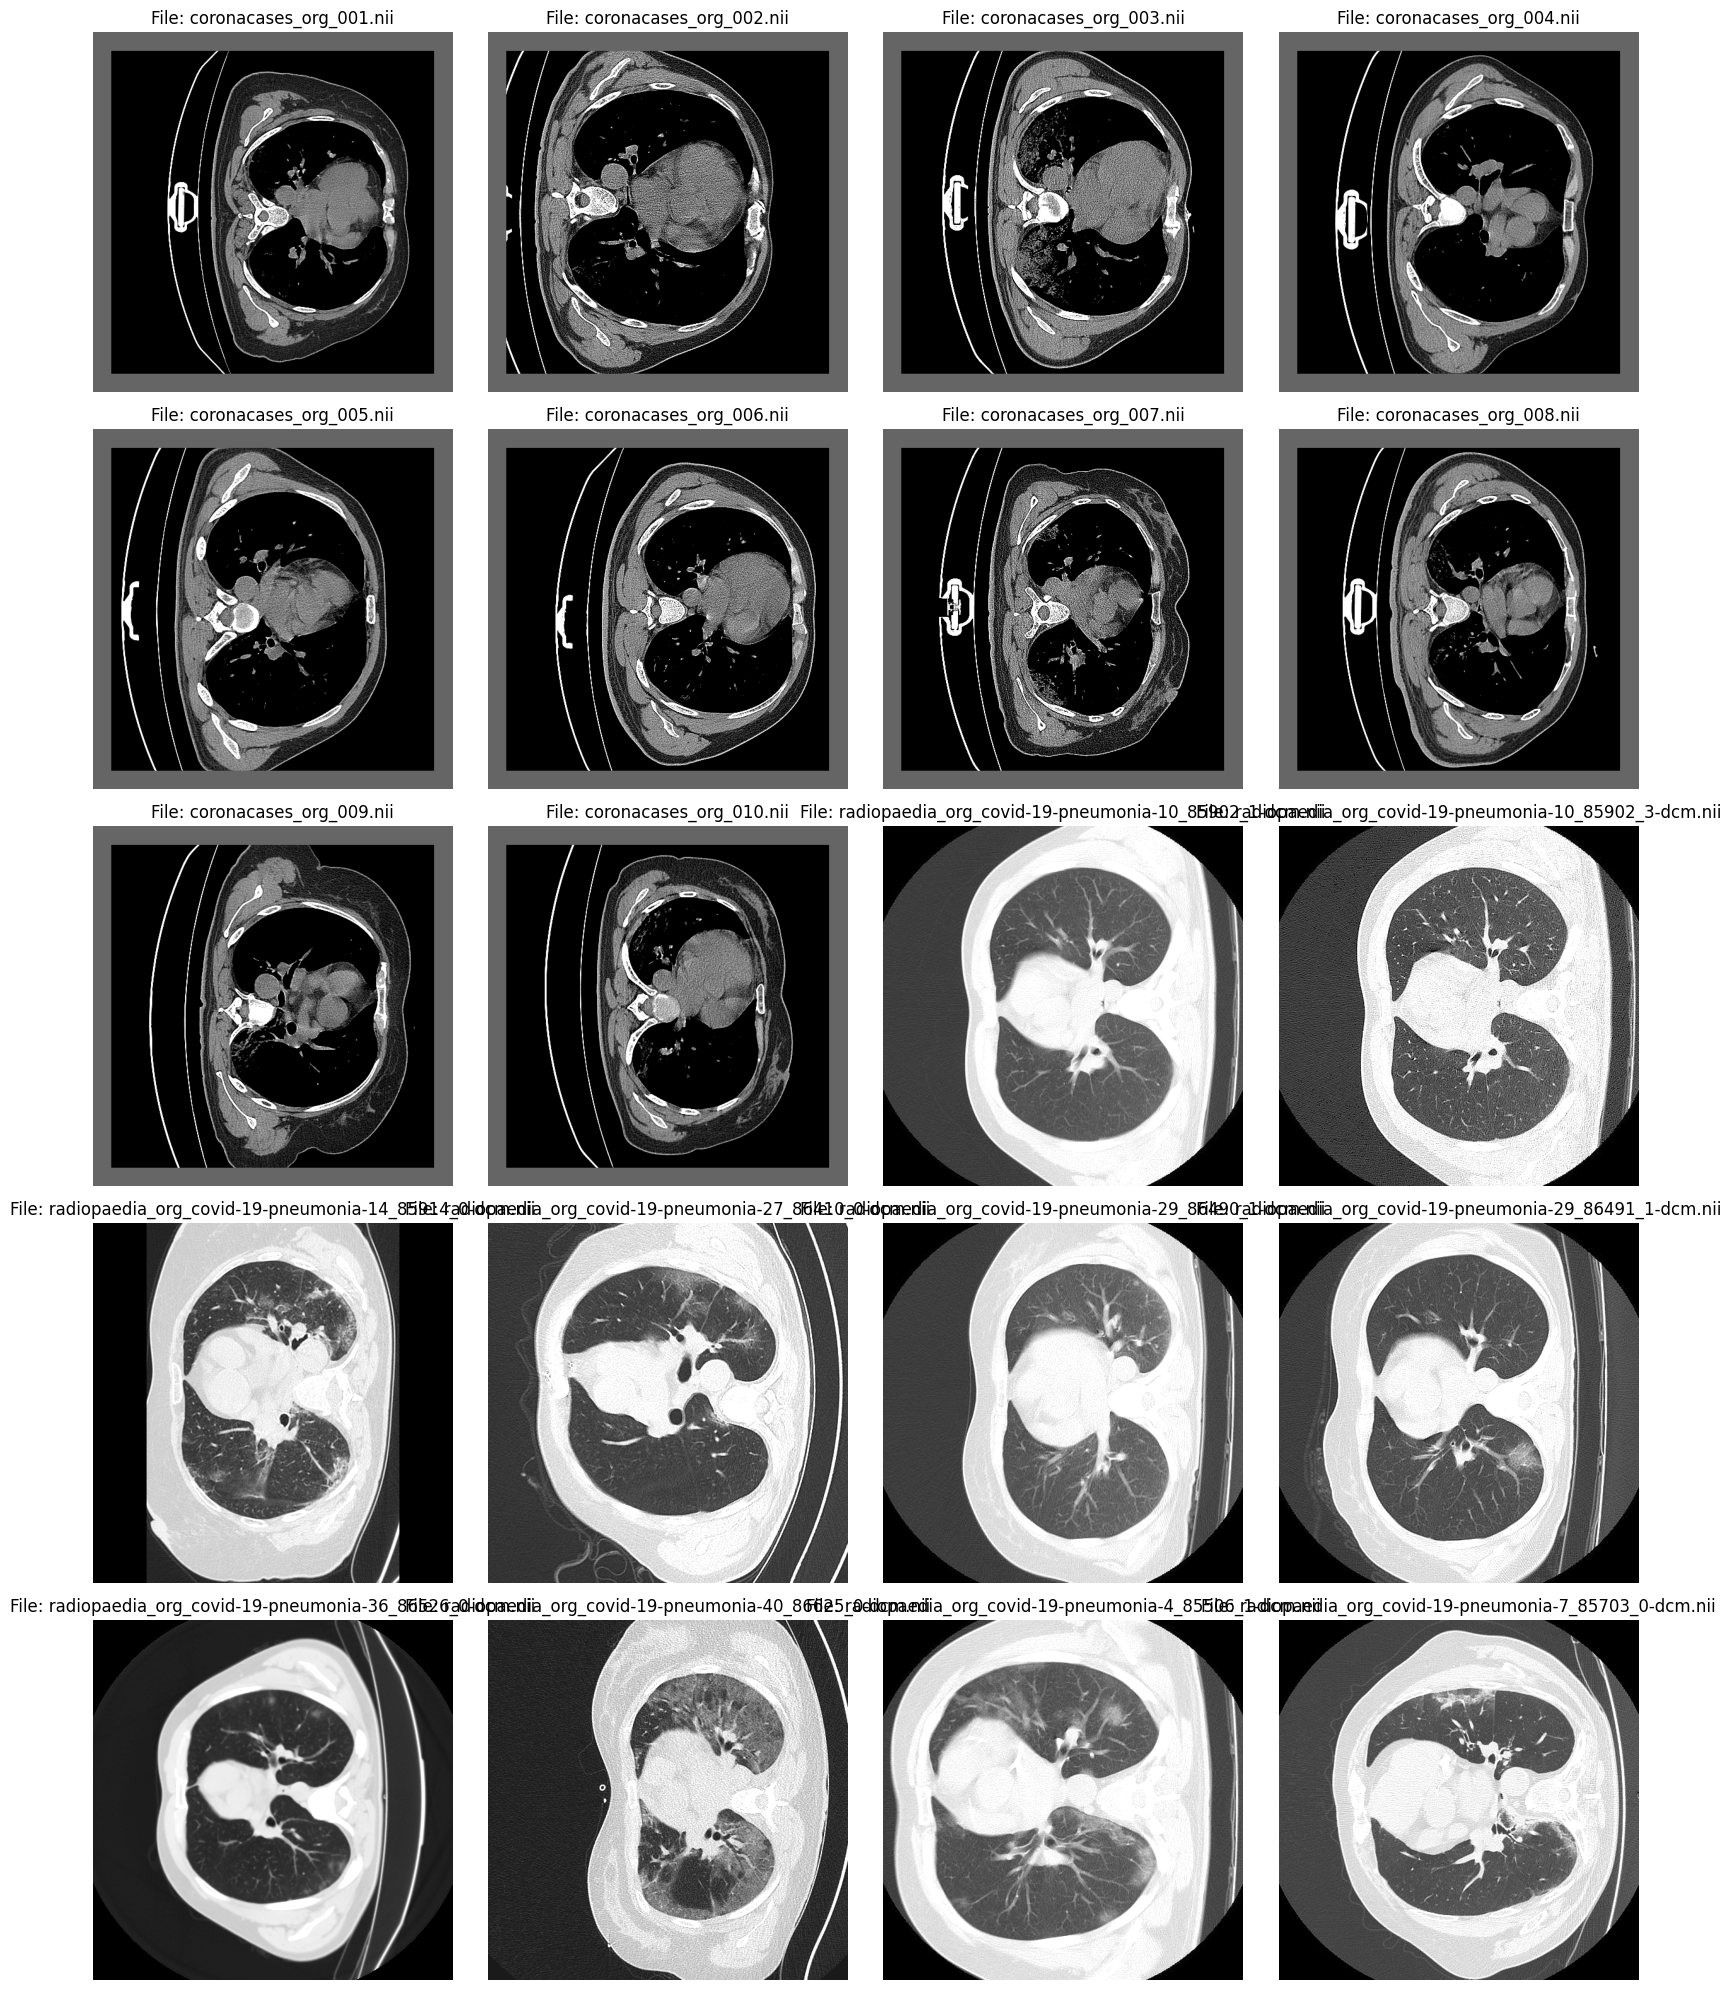

In [16]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def window_image(image, window_center, window_width):
    """
    Áp dụng window level và window width cho ảnh.
    """
    min_val = window_center - (window_width / 2)
    max_val = window_center + (window_width / 2)
    windowed_image = np.clip(image, min_val, max_val)
    normalized_image = (windowed_image - min_val) / (max_val - min_val) * 255.0
    return normalized_image.astype(np.uint8)

def calculate_grid(num_images):
    """
    Tính toán số hàng và số cột tối ưu dựa trên số lượng ảnh.
    """
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))
    return rows, cols

def show_multiple_images_v2(file_paths, window_center, window_width):
    """
    Hiển thị nhiều ảnh CT từ danh sách file với lưới tự động.
    """
    num_images = len(file_paths)
    if num_images == 0:
        print("Không có ảnh nào để hiển thị.")
        return

    # Tính toán lưới tối ưu
    rows, cols = calculate_grid(num_images)

    # Tạo biểu đồ
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = np.array(axes).flatten()  # Chuyển các trục thành danh sách phẳng

    for i, file_path in enumerate(file_paths):
        # Load ảnh từ file NIfTI
        img = nib.load(file_path)
        data = img.get_fdata()

        # Chọn lát cắt Axial giữa
        axial_slice_idx = data.shape[2] // 2
        axial_slice = data[:, :, axial_slice_idx]

        # Áp dụng windowing
        processed_image = window_image(axial_slice, window_center, window_width)

        # Hiển thị ảnh
        axes[i].imshow(processed_image, cmap='gray', origin='lower')
        axes[i].set_title(f"File: {os.path.basename(file_path)}")
        axes[i].axis("off")

    # Tắt các ô trống nếu số ảnh ít hơn số ô
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Thư mục chứa file đã giải mã
DECRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_ct_scans"
nii_files = [os.path.join(DECRYPTED_DIR, f) for f in os.listdir(DECRYPTED_DIR) if f.endswith('.nii')]

# Hiển thị ảnh
if nii_files:
    print(f"Hiển thị {len(nii_files)} ảnh đầu tiên:")
    # Window width và center cho mô mềm
    show_multiple_images_v2(nii_files, window_center=40, window_width=400)
else:
    print("Không có file NIfTI nào trong thư mục.")


Hiển thị 20 ảnh đầu tiên:


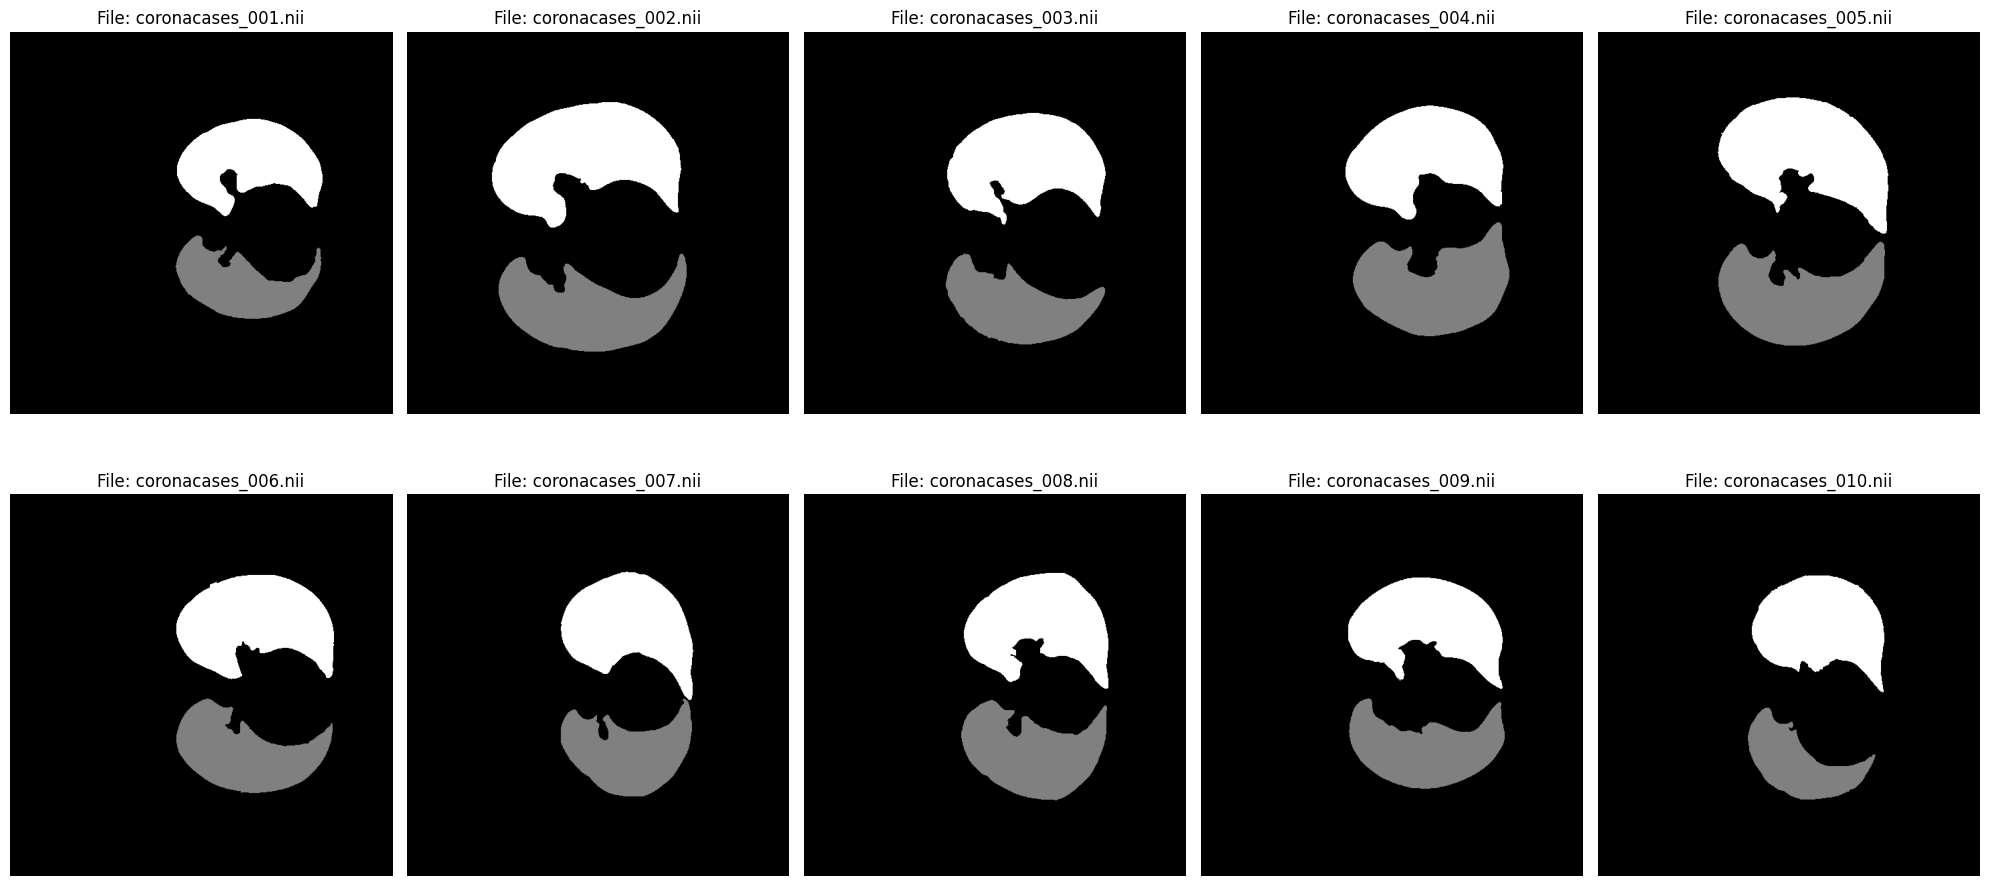

In [14]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến thư mục chứa file .nii
DECRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_lung_mask"

# Sắp xếp file NIFTI theo thứ tự tự nhiên
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in s.split('_')]

nii_files = sorted([f for f in os.listdir(DECRYPTED_DIR) if f.endswith('.nii')], key=natural_sort_key)

# Hàm để đọc và hiển thị file NIFTI
def display_lung_masks(file_list, folder_path, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i >= len(file_list):
            break
        file_path = os.path.join(folder_path, file_list[i])
        img = nib.load(file_path).get_fdata()

        # Chọn một lát cắt ở giữa hình 3D
        slice_idx = img.shape[2] // 2
        mask_slice = img[:, :, slice_idx]

        # Hiển thị ảnh với colormap gray
        axes[i].imshow(mask_slice, cmap='gray')
        axes[i].set_title(f"File: {file_list[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Hiển thị ảnh
if nii_files:
    print(f"Hiển thị {min(20, len(nii_files))} ảnh đầu tiên:")
    display_lung_masks(nii_files, DECRYPTED_DIR, rows=2, cols=5)
else:
    print("Không có file NIFTI nào trong thư mục.")


Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_001.nii


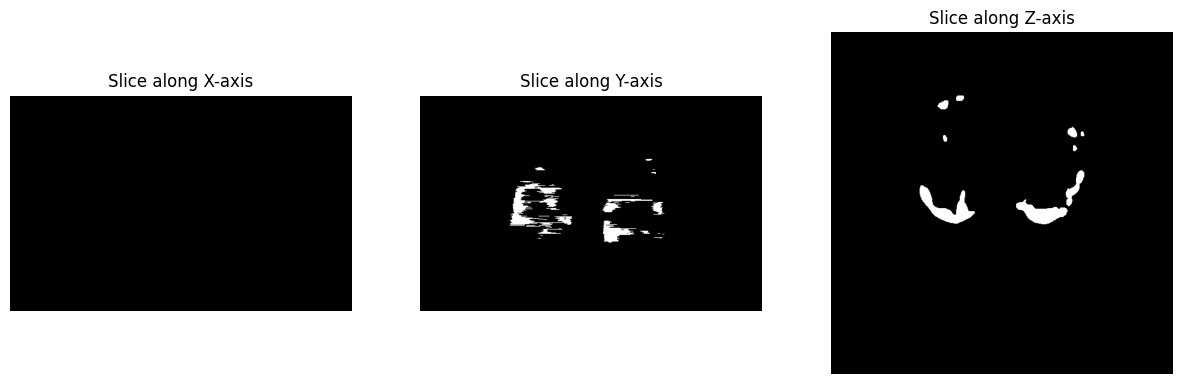

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_002.nii


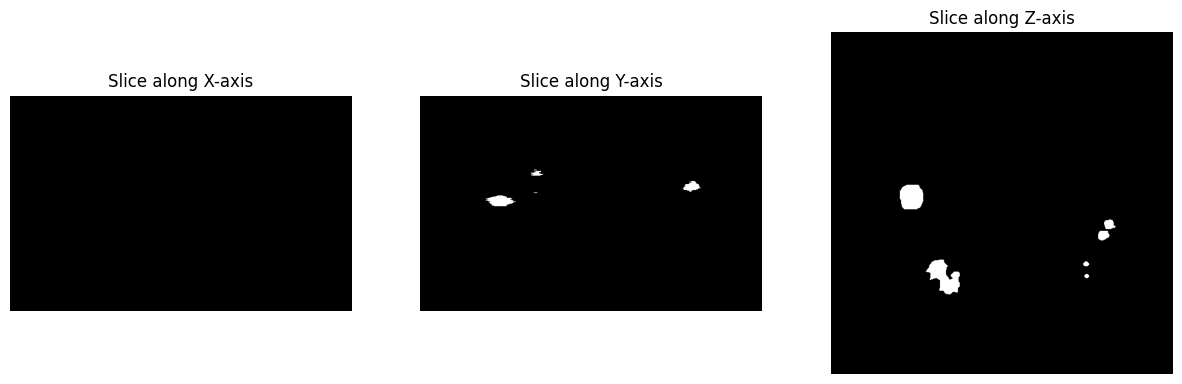

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_003.nii


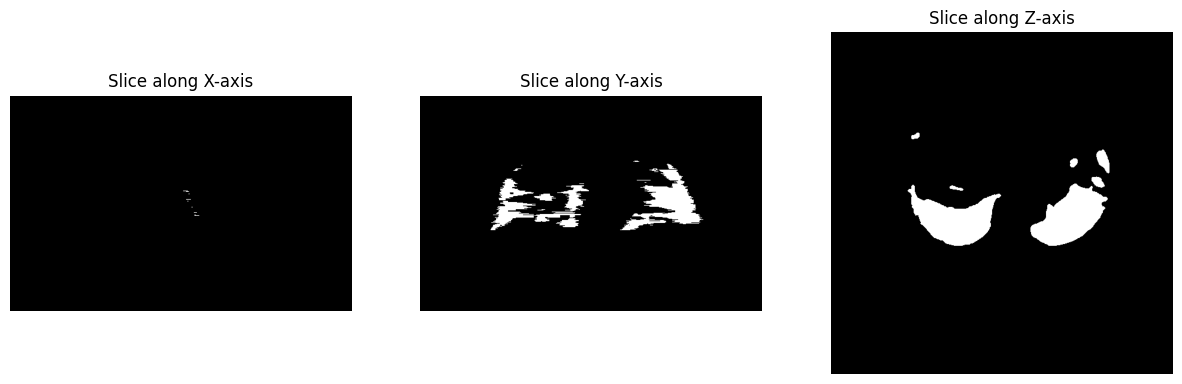

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_004.nii


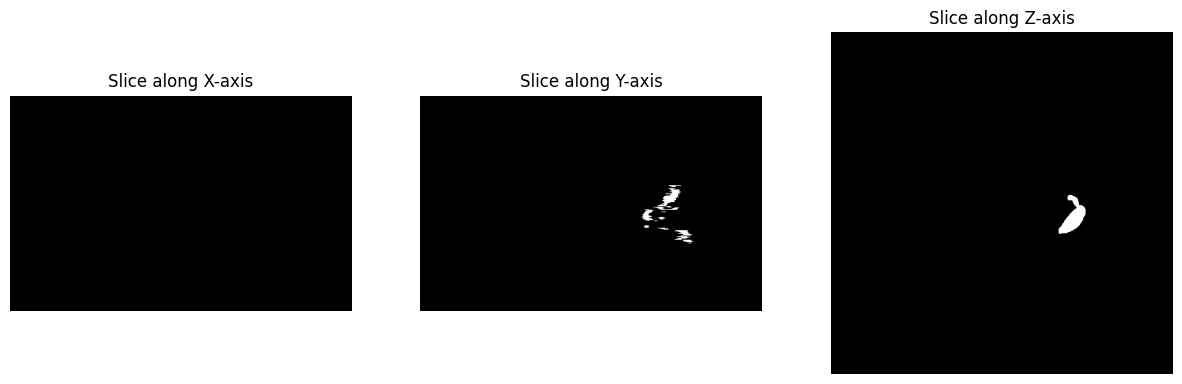

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_005.nii


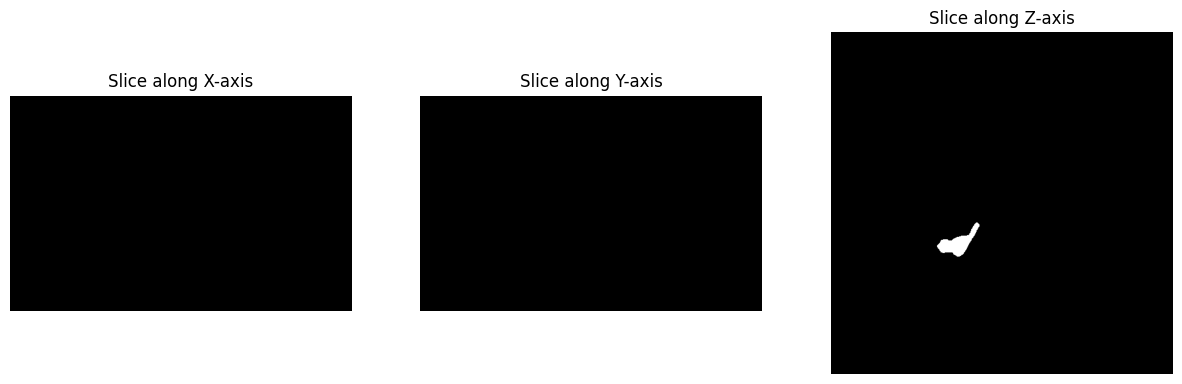

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_006.nii


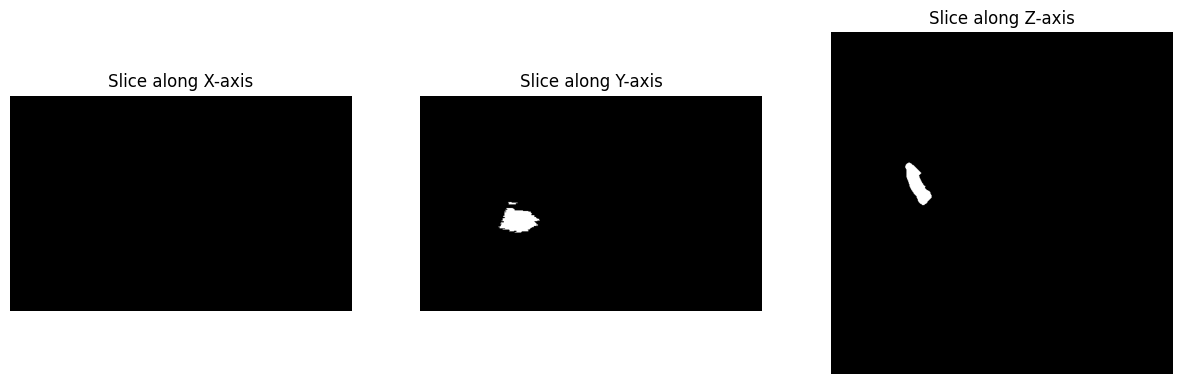

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_007.nii


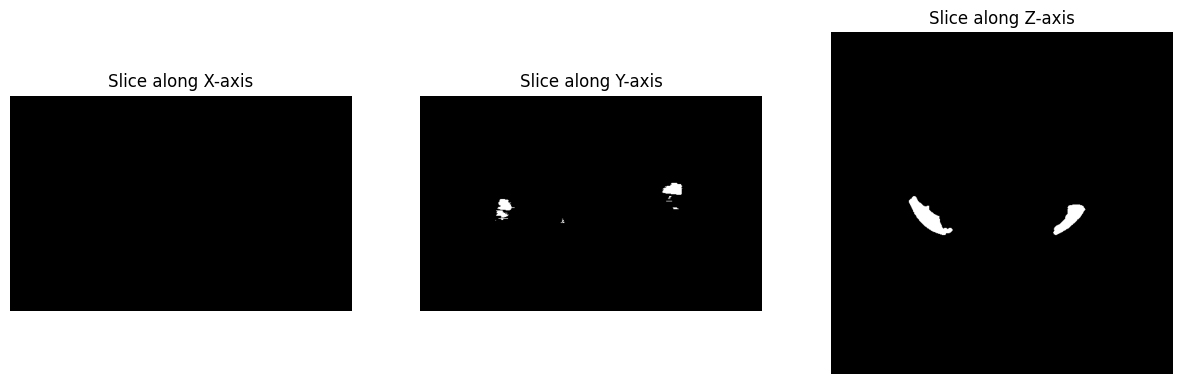

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_008.nii


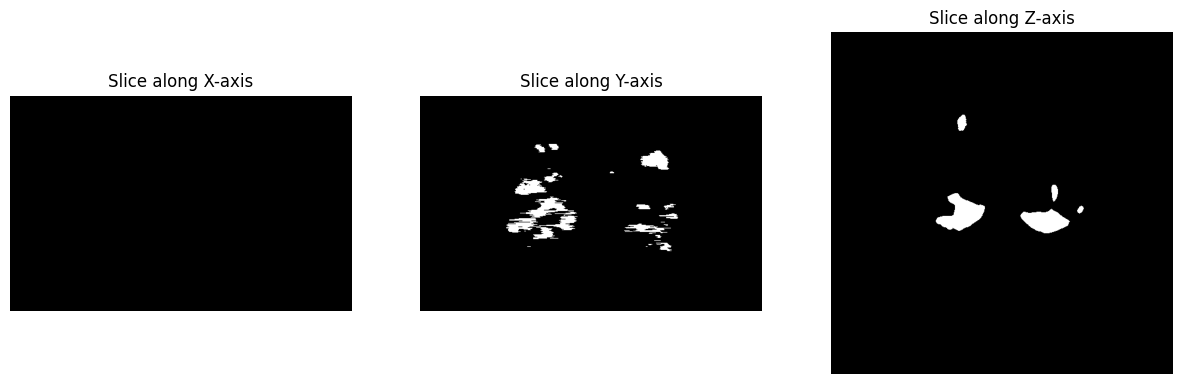

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_009.nii


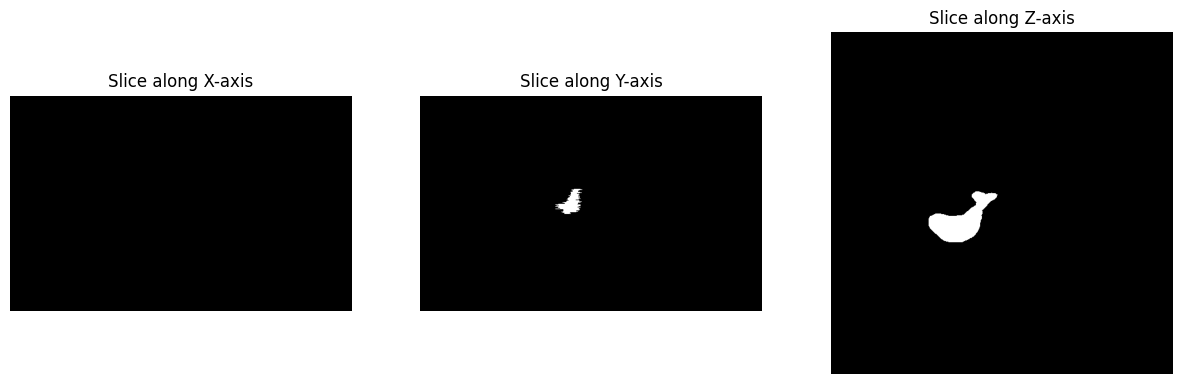

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_010.nii


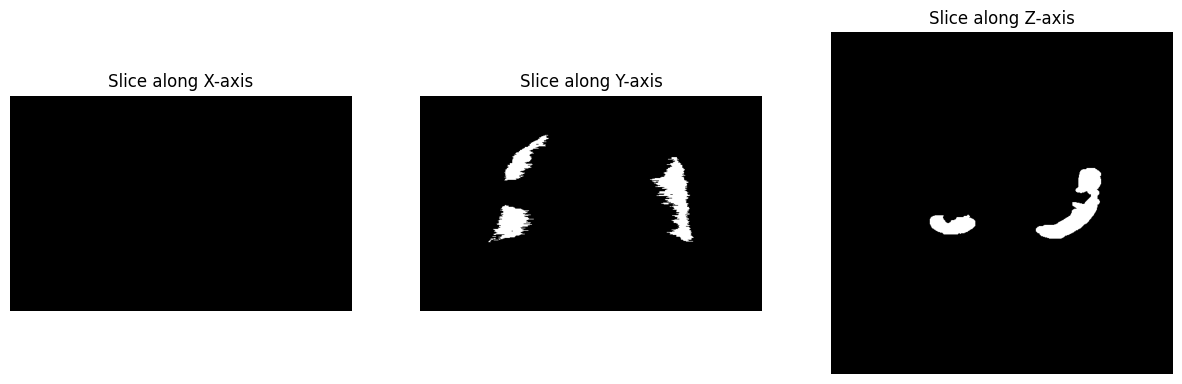

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_10_85902_1.nii


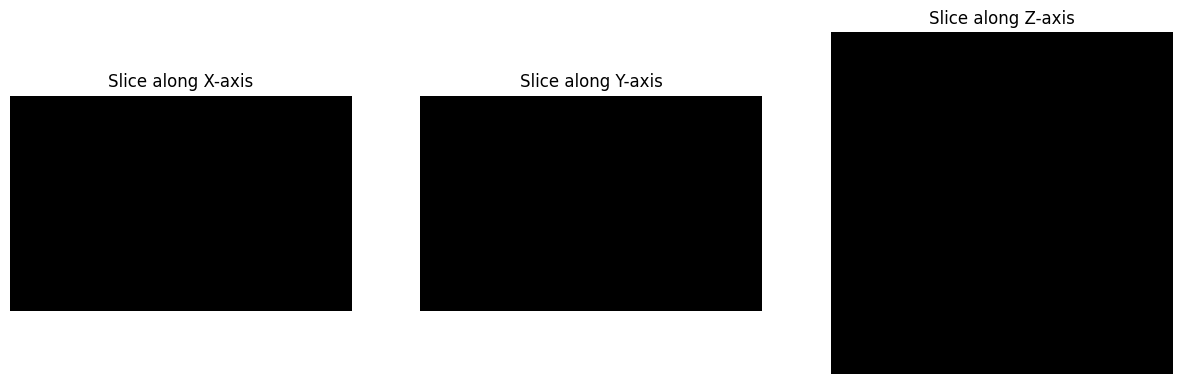

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_10_85902_3.nii


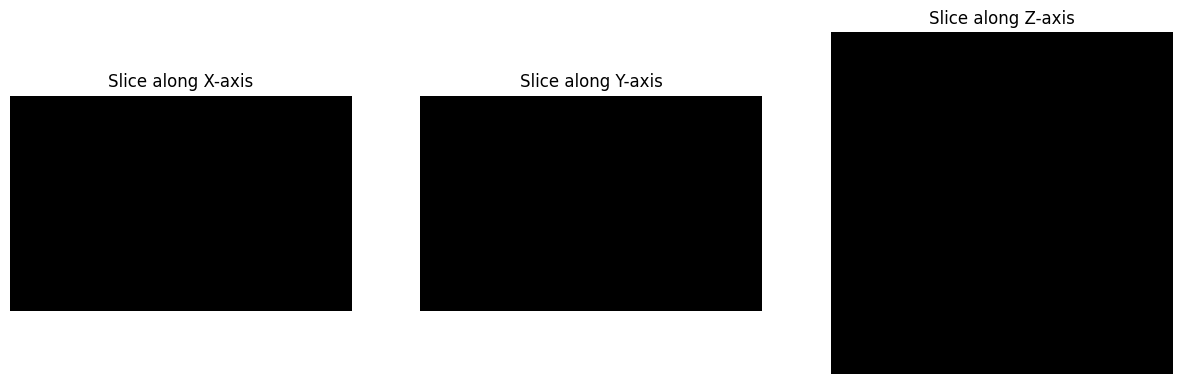

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_14_85914_0.nii


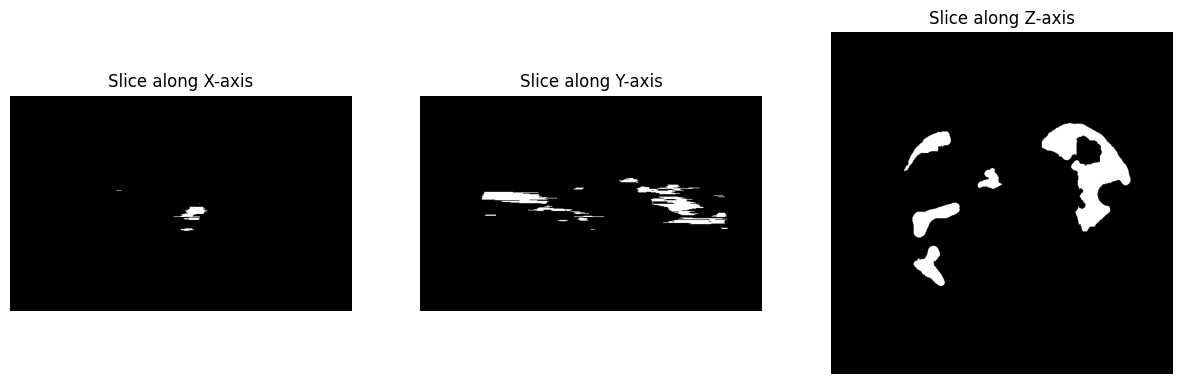

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_27_86410_0.nii


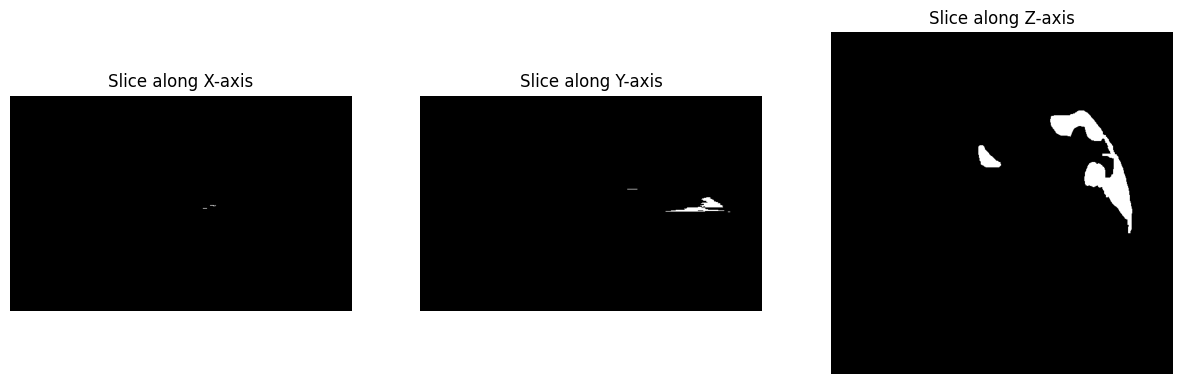

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_29_86490_1.nii


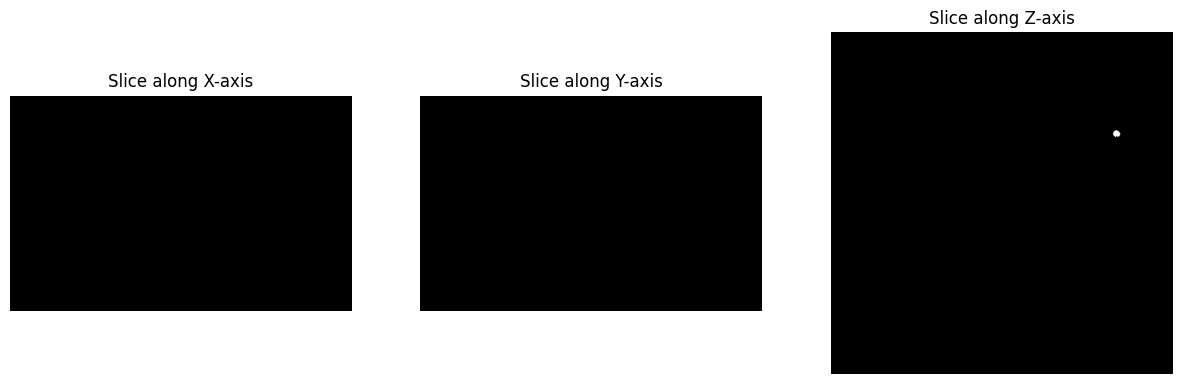

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_29_86491_1.nii


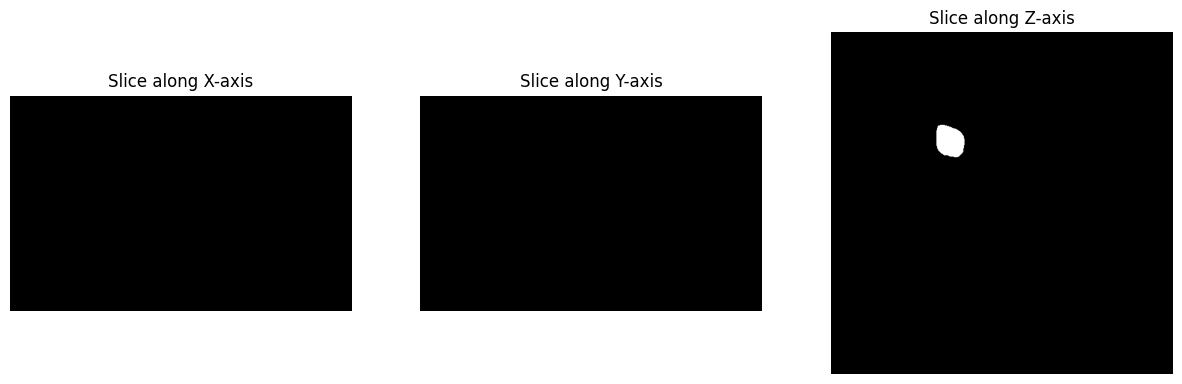

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_36_86526_0.nii


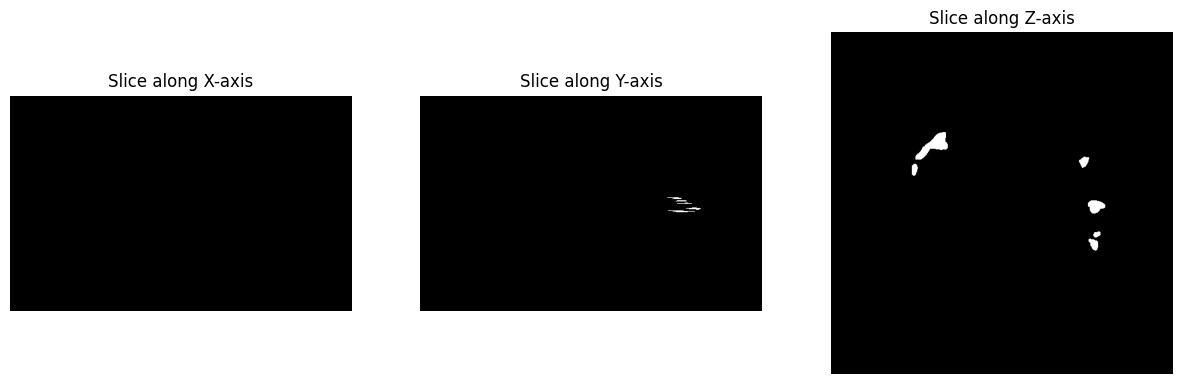

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_40_86625_0.nii


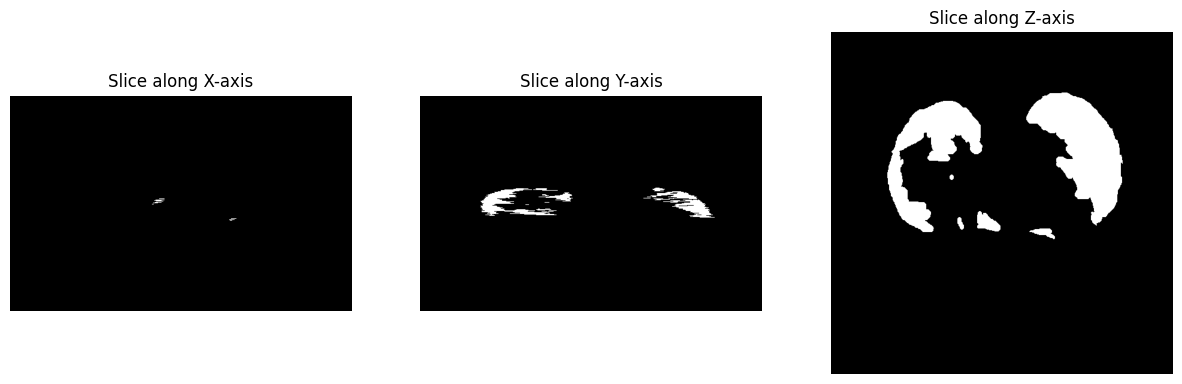

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_4_85506_1.nii


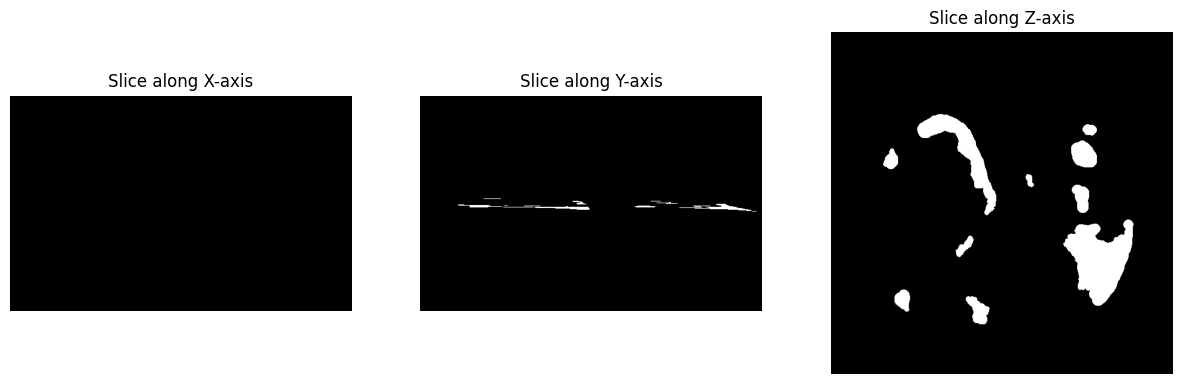

Hiển thị lát cắt của file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/radiopaedia_7_85703_0.nii


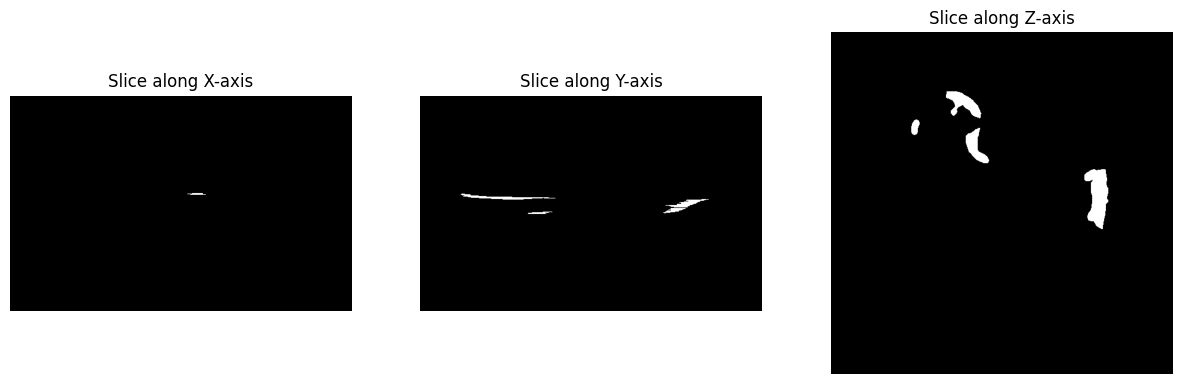

In [15]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

# Thư mục chứa các file đã giải mã
DECRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask"

# Danh sách file .nii đã giải mã
nii_files = [os.path.join(DECRYPTED_DIR, f) for f in os.listdir(DECRYPTED_DIR) if f.endswith('.nii')]

# Hiển thị lát cắt của một số ảnh
def show_slices(image_data, num_slices=3):
    """
    Hiển thị các lát cắt của ảnh 3D.
    :param image_data: Ảnh 3D dưới dạng mảng NumPy.
    :param num_slices: Số lát cắt hiển thị.
    """
    mid_slices = [dim // 2 for dim in image_data.shape]  # Lấy tọa độ giữa của từng trục
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

    for i, axis in enumerate(range(num_slices)):
        if axis == 0:
            slice_data = image_data[mid_slices[0], :, :]  # Lát cắt trục X
            axes[i].imshow(slice_data.T, cmap="gray", origin="lower")
            axes[i].set_title("Slice along X-axis")
        elif axis == 1:
            slice_data = image_data[:, mid_slices[1], :]  # Lát cắt trục Y
            axes[i].imshow(slice_data.T, cmap="gray", origin="lower")
            axes[i].set_title("Slice along Y-axis")
        elif axis == 2:
            slice_data = image_data[:, :, mid_slices[2]]  # Lát cắt trục Z
            axes[i].imshow(slice_data.T, cmap="gray", origin="lower")
            axes[i].set_title("Slice along Z-axis")

        axes[i].axis("off")
    plt.show()

# Hiển thị lát cắt từ các file .nii
for nii_file in nii_files[:20]:  # Chỉ hiển thị tối đa 5 file
    img = nib.load(nii_file)  # Tải file .nii
    data = img.get_fdata()    # Lấy dữ liệu ảnh dưới dạng NumPy array
    print(f"Hiển thị lát cắt của file: {nii_file}")
    show_slices(data)


Hiển thị 20 ảnh đầu tiên:


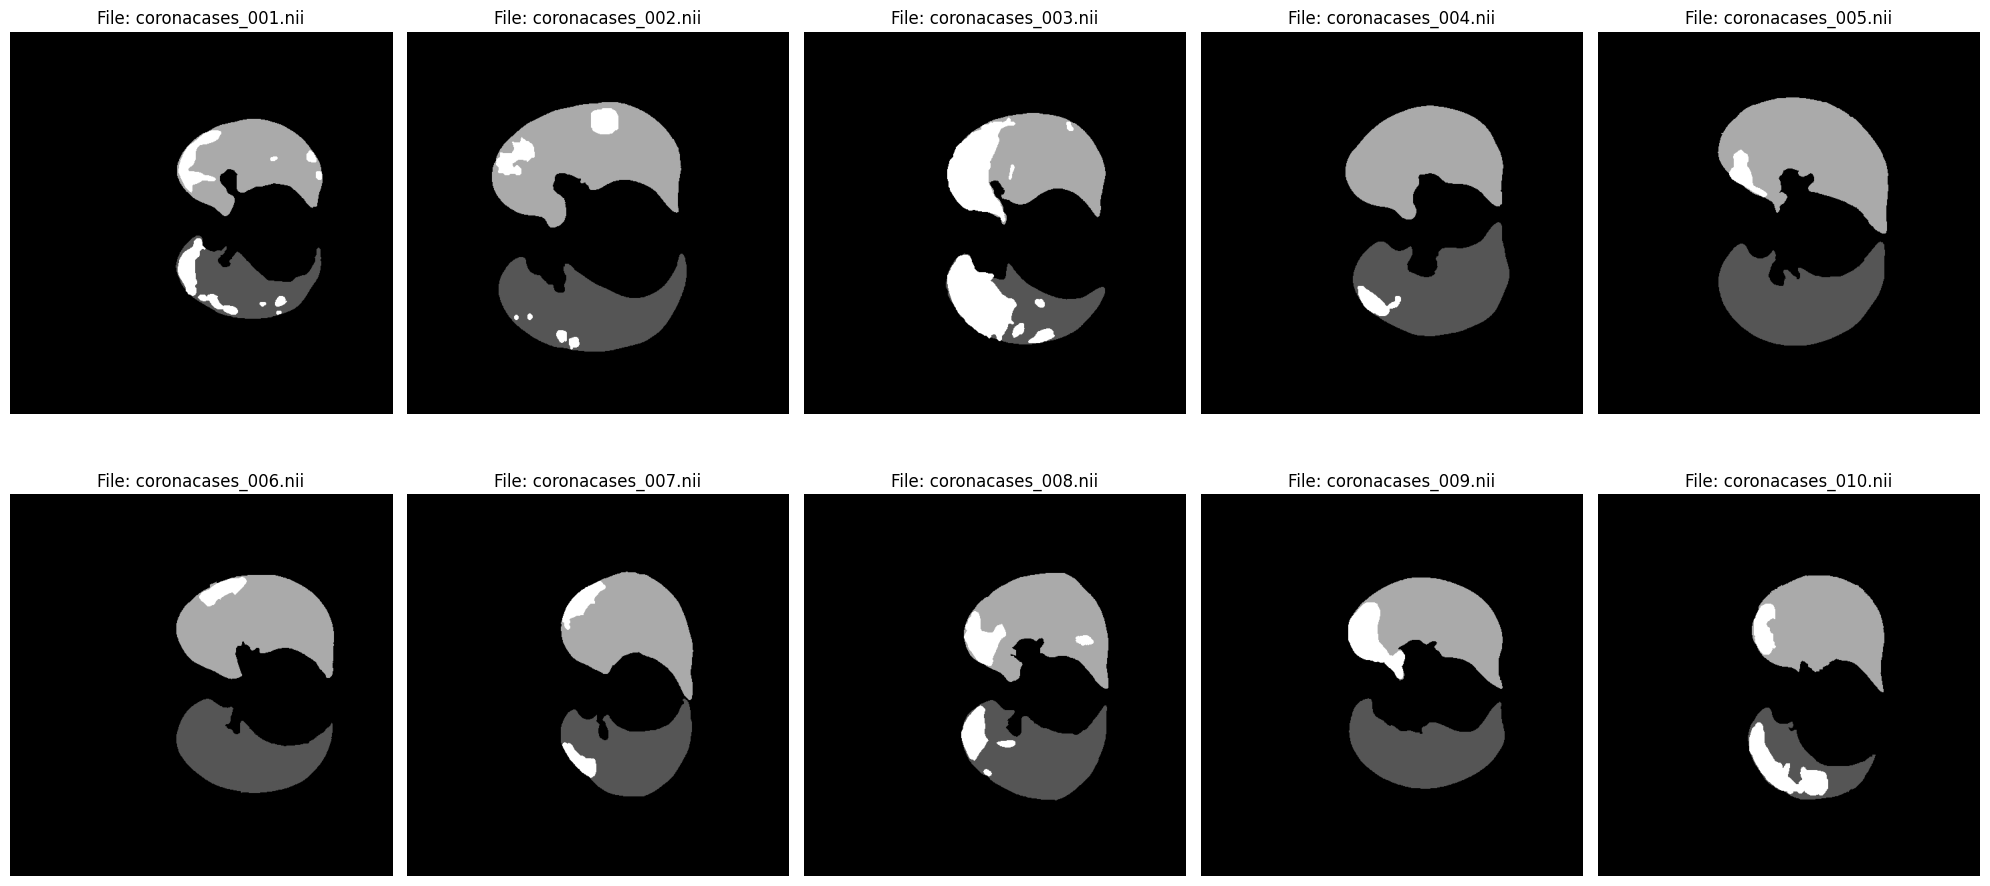

In [12]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến thư mục chứa file .nii
DECRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_lung_and_infection_mask"

# Sắp xếp file NIFTI theo thứ tự tự nhiên
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in s.split('_')]

nii_files = sorted([f for f in os.listdir(DECRYPTED_DIR) if f.endswith('.nii')], key=natural_sort_key)

# Hàm để đọc và hiển thị file NIFTI
def display_lung_masks(file_list, folder_path, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i >= len(file_list):
            break
        file_path = os.path.join(folder_path, file_list[i])
        img = nib.load(file_path).get_fdata()

        # Chọn một lát cắt ở giữa hình 3D
        slice_idx = img.shape[2] // 2
        mask_slice = img[:, :, slice_idx]

        # Hiển thị ảnh với colormap gray
        axes[i].imshow(mask_slice, cmap='gray')
        axes[i].set_title(f"File: {file_list[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Hiển thị ảnh
if nii_files:
    print(f"Hiển thị {min(20, len(nii_files))} ảnh đầu tiên:")
    display_lung_masks(nii_files, DECRYPTED_DIR, rows=2, cols=5)
else:
    print("Không có file NIFTI nào trong thư mục.")


Hiển thị infection mask cho file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_001.nii


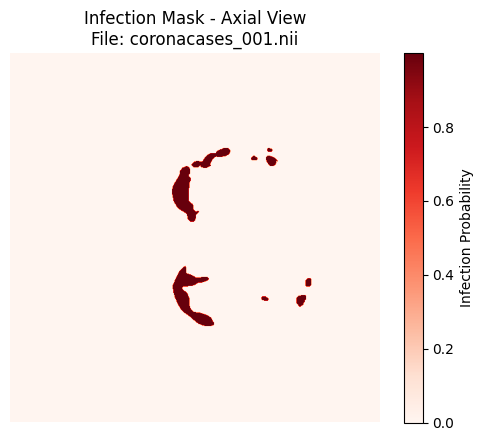

Hiển thị infection mask cho file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_002.nii


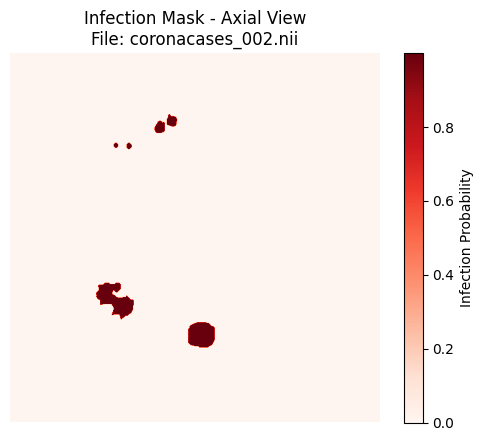

Hiển thị infection mask cho file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_003.nii


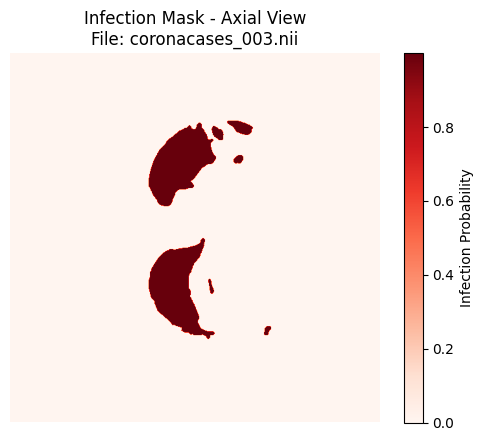

Hiển thị infection mask cho file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_004.nii


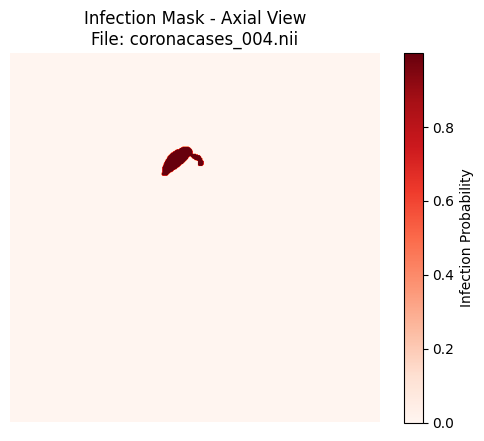

Hiển thị infection mask cho file: /content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask/coronacases_005.nii


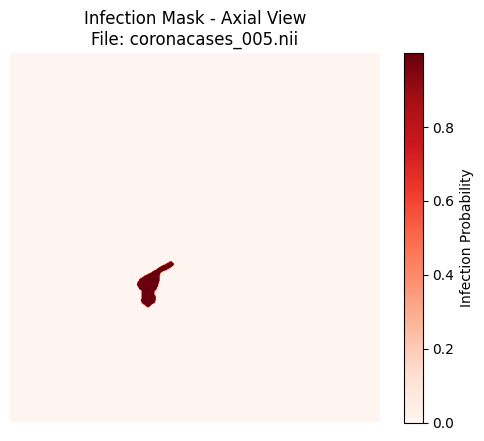

In [10]:
# prompt: code python show infection_mask ro rang hon, co mau sac  chuan y hoc de de chan doan

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os

# ... (Your existing code) ...

def show_infection_mask(file_path):
    """
    Hiển thị infection mask với màu sắc chuẩn y học.
    """
    try:
        # Load ảnh từ file NIfTI
        img = nib.load(file_path)
        data = img.get_fdata()

        # Chọn lát cắt Axial giữa
        axial_slice_idx = data.shape[2] // 2
        axial_slice = data[:, :, axial_slice_idx]

        # Tạo màu sắc chuẩn y học (ví dụ: vùng nhiễm trùng màu đỏ)
        plt.imshow(axial_slice, cmap='Reds', origin='lower')  # Sử dụng cmap='Reds'

        plt.title(f"Infection Mask - Axial View\nFile: {os.path.basename(file_path)}")
        plt.axis("off")
        plt.colorbar(label="Infection Probability")  # Thêm colorbar
        plt.show()

    except Exception as e:
        print(f"Lỗi khi hiển thị ảnh: {e}")


# Thư mục chứa file infection mask đã giải mã
DECRYPTED_DIR = "/content/drive/MyDrive/data-bigdatatechnlogy/BigData-project/decrypted_data/encrypted_infection_mask"
nii_files = [os.path.join(DECRYPTED_DIR, f) for f in os.listdir(DECRYPTED_DIR) if f.endswith('.nii')]

# Hiển thị infection mask cho một vài file đầu tiên
for nii_file in nii_files[:5]: # Hiển thị 5 file đầu tiên
    print(f"Hiển thị infection mask cho file: {nii_file}")
    show_infection_mask(nii_file)